<a href="https://colab.research.google.com/github/saby537/Neural_Style_Transfer/blob/master/Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

import numpy as np
from PIL import Image
import time
import functools

In [3]:
%tensorflow_version 1.x
import tensorflow as tf

from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

TensorFlow 1.x selected.


In [4]:
tf.enable_eager_execution();
print("Eager Execution: {}".format(tf.executing_eagerly()))

Eager Execution: True


In [5]:
content_path = "/content/Green_Sea_Turtle_grazing_seagrass.jpg"
style_path = "/content/The_Great_Wave_off_Kanagawa.jpg"

In [6]:
def load_img(image_path):
  max_dim = 512
  img = Image.open(image_path)
  long = max(img.size)
  scale = max_dim/long
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
  img = kp_image.img_to_array(img)
  img = np.expand_dims(img,axis=0);
  return img

In [7]:
def imshow(img, title=None):
  out = np.squeeze(img,axis=0)
  out = out.astype('uint8')
  plt.imshow(out)
  if(title is not None):
    plt.title(title)
  plt.imshow(out)

In [8]:
def load_and_process_img(img_path):
  img = load_img(img_path)
  img = tf.keras.applications.vgg19.preprocess_input(img)
  return img

In [9]:
def load_and_process_init_img(content_path):
  img = load_img(content_path)
  ar = np.zeros((img.shape))
  for i in range(ar.shape[1]):
    for j in range(ar.shape[2]):
      ch = np.random.choice([0,255])
      ar[0,i,j] = [ch,ch,ch]
  ar = tf.keras.applications.vgg19.preprocess_input(ar)
  return ar

In [10]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x,0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  x[:,:,0] += 103.939
  x[:,:,1] += 116.779
  x[:,:,2] += 123.68
  x = x[:,:,::-1]

  x = np.clip(x,0,255).astype('uint8')
  return x

In [11]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1'
                ]
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [12]:
def get_model():
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  style_outputs = [vgg.get_layer(name).output for name in style_layers]
  content_outputs = [vgg.get_layer(name).output for name in content_layers]
  model_outputs = style_outputs + content_outputs

  return models.Model(vgg.input,model_outputs)

In [13]:
def get_content_loss(base_content,target):
  return tf.reduce_mean(tf.square(base_content - target))

In [14]:
def gram_matrix(input_tensor):
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor,[-1,channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a,a,transpose_a=True)
  return gram/tf.cast(n,tf.float32)

In [15]:
def get_style_loss(base_style,gram_target):
  height, width, channels = base_style.get_shape().as_list()
  gram_style = gram_matrix(base_style)
  return tf.reduce_mean(tf.square(gram_style - gram_target))

In [16]:
def get_feature_representations(model,content_path,style_path):
  content_image = load_and_process_img(content_path)
  style_image = load_and_process_img(style_path)

  style_outputs = model(style_image)
  content_outputs = model(content_image)

  style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
  content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
  return style_features, content_features

In [17]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
  style_weight, content_weight = loss_weights
  model_outputs = model(init_image)

  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]

  style_score = 0;
  content_score = 0;

  weight_per_content_layer = 1.0 / float(num_content_layers)
  for target_content, comb_content in zip(content_features,content_output_features):
    content_score += weight_per_content_layer * get_content_loss(comb_content[0],target_content)

  weight_per_style_layer = 1.0 / float(num_style_layers)
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer * get_style_loss(comb_style[0],target_style)
  
  style_score *= style_weight
  content_score *= content_weight

  loss = style_score + content_score
  return loss, style_score, content_score


In [18]:
def compute_grads(cfg):
  with tf.GradientTape() as tape:
    all_loss = compute_loss(**cfg)
  total_loss = all_loss[0]
  return tape.gradient(total_loss,cfg['init_image']), all_loss  

In [19]:
import IPython.display

def run_style_transfer(content_path, 
                       style_path,
                       num_iterations=1000,
                       content_weight=1e3, 
                       style_weight=1e-2): 
  model = get_model() 
  for layer in model.layers:
    layer.trainable = False
  
  style_features, content_features = get_feature_representations(model, content_path, style_path)
  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
  
  #init_image = load_and_process_init_img(content_path)
  init_image = load_and_process_img(content_path)
  init_image = tf.Variable(init_image, dtype=tf.float32)
  
  opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)
  iter_count = 1
  best_loss, best_img = float('inf'), None
  
  loss_weights = (style_weight, content_weight)
  cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
  }
    
  num_rows = 2
  num_cols = 5
  display_interval = num_iterations/(num_rows*num_cols)
  global_start = time.time()
  
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means   
  
  imgs = []
  for i in range(num_iterations):
    start_time = time.time()
    grads, all_loss = compute_grads(cfg)
    loss, style_score, content_score = all_loss
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    
    if loss < best_loss:
      best_loss = loss
      best_img = deprocess_img(init_image.numpy())

    if i % 50 == 0:
      # Use the .numpy() method to get the concrete numpy array
      plot_img = init_image.numpy()
      plot_img = deprocess_img(plot_img)
      IPython.display.clear_output(wait=True)
      IPython.display.display_png(Image.fromarray(plot_img))
      print(i)
      print('Iteration: {}'.format(i))        
      print('Total loss: {:.4e}, ' 
            'style loss: {:.4e}, '
            'content loss: {:.4e}, '
            'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
      if i % display_interval == 0:
          imgs.append(plot_img)
  print('Total time: {:.4f}s'.format(time.time() - global_start))
  IPython.display.clear_output(wait=True)
  plt.figure(figsize=(14,4))
  for i,img in enumerate(imgs):
      plt.subplot(num_rows,num_cols,i+1)
      plt.imshow(img)
      plt.xticks([])
      plt.yticks([])
      
  return best_img, best_loss 

In [21]:
def show_results(best_img, content_path, style_path, show_large_final = True):
  plt.figure(figsize=(10,5))
  content = load_img(content_path)
  style = load_img(style_path)
  
  plt.subplot(1,2,1)
  imshow(content, 'Content Image')

  plt.subplot(1,2,2)
  imshow(style, 'Style Image')

  if show_large_final:
    plt.figure(figsize=(10,10))

    plt.imshow(best_img)
    plt.title('Output Image')
    plt.show()


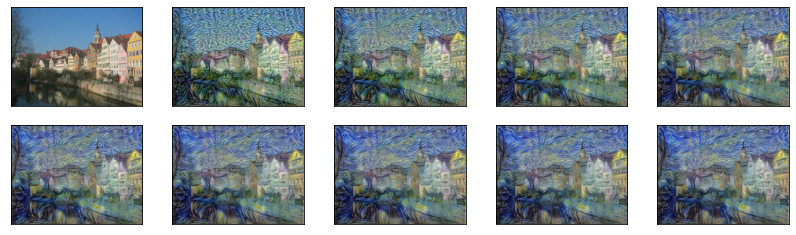

In [22]:
best, best_loss = run_style_transfer("/content/Tuebingen_Neckarfront.jpg","/content/Starry_night.jpg",num_iterations=1000)

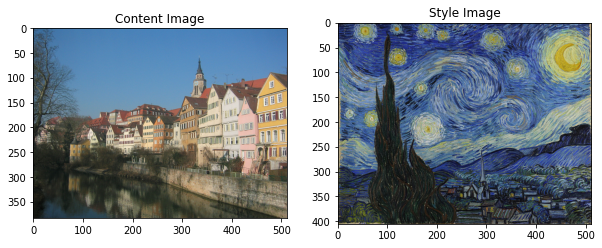

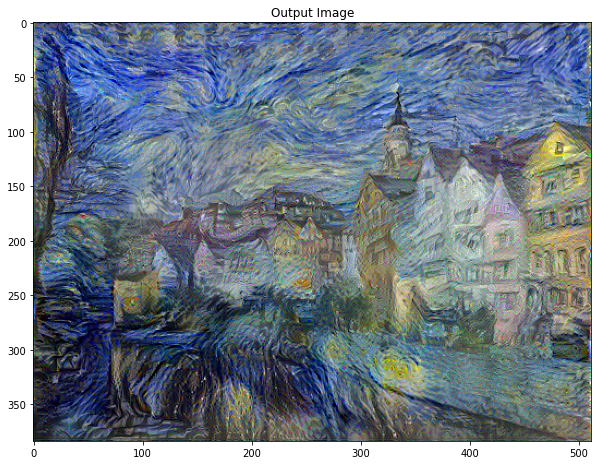

In [24]:
show_results(best,"/content/Tuebingen_Neckarfront.jpg","/content/Starry_night.jpg")

In [25]:
model = get_model()
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

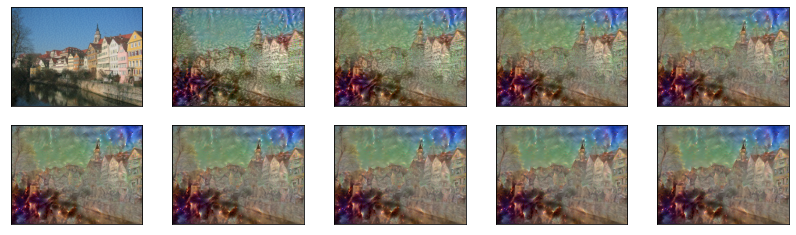

In [26]:
best, best_loss = run_style_transfer("/content/Tuebingen_Neckarfront.jpg","/content/Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg",num_iterations=1000)

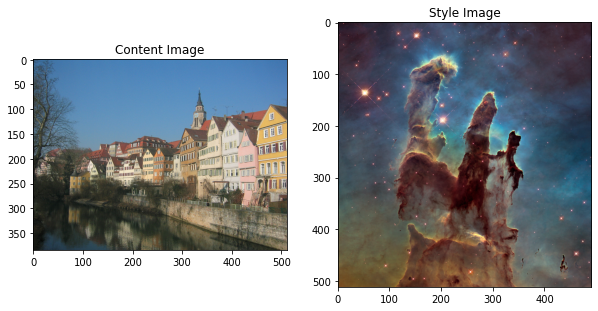

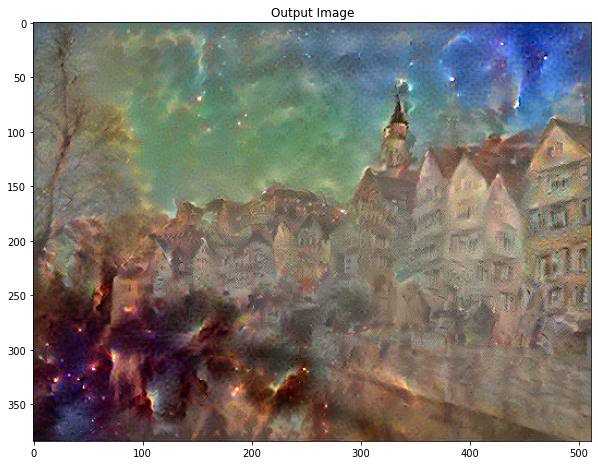

In [27]:
show_results(best,"/content/Tuebingen_Neckarfront.jpg","/content/Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg")